# Model Random Forest

In [1]:
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV,RepeatedKFold, RepeatedStratifiedKFold, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_data(raw_clinical_note):
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    return data

def delete_columns(data,columns): 
    df = data.drop(columns,axis=1)
    return df

def generating_metrics(model,x, y):
    y_pred_proba = model.predict_proba(x)[:, 1]
    y_pred = model.predict(x)
    acc = accuracy_score(y,y_pred)
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    auc_score = auc(false_positive_rate, true_positive_rate)
    f1 = f1_score(y, y_pred)
    return auc_score, sensitivity, specificity, f1, acc, false_positive_rate, true_positive_rate

def plot_roc(model,X_test, y_test,name,logs_file):
    print("mean_cross_val_score: ", model.best_score_)
    print("best_params:",model.best_params_)
    print("=============================================================================")
    auc_test, sens_test, spec_test, f1_test, acc_test,fpr_test, tpr_test = generating_metrics(model, X_test, y_test)
    print("auc_test: {}, sens_test {}, spec_test: {}, f1_test {}, acc_test {}".format(auc_test, sens_test, spec_test, f1_test, acc_test))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_test, tpr_test, label='Testing (AUC=%0.2f)' % auc_test, color='darkorange')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc='best')
    plt.title('ROC of the RF model')
    fig_name = name + '.pdf'
    url_save = os.path.join(logs_file,str(fig_name))
    plt.savefig(url_save)
    plt.show()

def saving_model(model,model_name,logs_file):
    import joblib
    model_name = model_name + '.pkl'
    url_save = os.path.join(logs_file,str(model_name))
    print(url_save)
    joblib.dump(model, url_save)

def saving_metrics(model_name, logs_file, num_features, auc_train
                   ,auc_val, sens_val, spec_val, f1_val, acc_val
                   ,auc_test, sens_test, spec_test, f1_test, acc_test,fpr, tpr):
    """ Saving final metrics in csv file.
    Metrics generated during training, validation, testing steps are saved"""
    name = pd.DataFrame({'model_name':model_name}, index=[0])
    num_features = pd.DataFrame({'num_features':num_features}, index=[0])
    auc_train = pd.DataFrame({'auc_train':auc_train},index = [0])
    auc_val = pd.DataFrame({'auc_val':auc_val},index = [0])
    sens_val = pd.DataFrame({'sens_val':sens_val},index = [0])
    spec_val = pd.DataFrame({'spec_val':spec_val},index = [0])
    f1_val = pd.DataFrame({'f1_val':f1_val},index = [0])
    acc_val = pd.DataFrame({'acc_val':acc_val},index = [0])
    auc_test = pd.DataFrame({'auc_test':auc_test},index = [0])
    sens_test = pd.DataFrame({'sens_test':sens_test},index = [0])
    spec_test = pd.DataFrame({'spec_test':spec_test},index = [0])
    f1_test = pd.DataFrame({'f1_test':f1_test},index = [0])
    acc_test = pd.DataFrame({'acc_test':acc_test},index = [0])

    fpr = str(fpr)
    tpr = str(tpr)
    fpr = pd.DataFrame({'false_positive_rate':fpr},index = [0])
    tpr = pd.DataFrame({'true_positive_rate':tpr},index = [0])

    frames = [name, num_features, auc_train, auc_val,sens_val,spec_val,f1_val,acc_val,
              auc_test,sens_test,spec_test,f1_test,acc_test, fpr, tpr]
    resultado = pd.concat(frames, axis = 1)
    url_log = model_name +'_metrics.csv'
    url_log = os.path.join(logs_file,str(url_log))
    resultado.to_csv(url_log)

In [3]:
raw_data = 'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/data_morelos_rename.csv'
data = pd.read_csv(raw_data)
print ("Total de registros", data.shape[0])

Total de registros 12103


In [4]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Sex', 'LOCRESI',
       'Evolution', 'Intubated ', 'Age', 'Pregnancy', 'FECINGRE', 'FECINISI',
       'Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'VIH-SIDA',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'RECTRATA',
       'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'Puerperium', 'Use of antipyretics',
       'ICU', 'CLASCOVID19', 'Days elapsed', 'HIV AIDS', 'Mortality'],
      dtype='object')

In [5]:
X = data.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality'],axis=1).astype(int)
y = data['Mortality'].astype(int) 
y = y.values.reshape(y.shape[0],1)
feature_list = X.columns
print("X::", X.shape)
print("Y::", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=242,stratify=y)

X:: (12103, 39)
Y:: (12103, 1)


In [6]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [7]:
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
sample_weights = class_weight.compute_sample_weight('balanced', y_train)
parameters={"n_estimators":[100, 150, 200], 
            "max_features": ['log2'],
           "max_depth" : [2, 4, 6, 8],
            "min_impurity_decrease":[1e-4],
            "criterion":['gini'],
           "class_weight":['balanced'],
            "random_state": [422]}
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, cv = cv, scoring='roc_auc',refit = True)
model = grid.fit(X_train,y_train,sample_weight = sample_weights)

mean_cross_val_score:  0.853821217554385
best_params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_impurity_decrease': 0.0001, 'n_estimators': 100, 'random_state': 422}
auc_test: 0.7267058885526296, sens_test 0.9923664122137404, spec_test: 0.46104536489151876, f1_test 0.4157782515991471, acc_test 0.5472945064023131


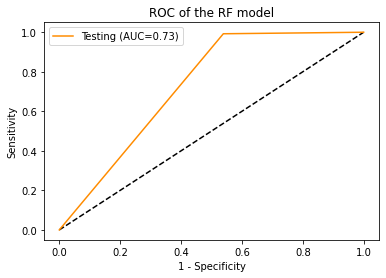

In [8]:
generating_metrics(model,X_test, y_test)
plot_roc(model,X_test, y_test,"auc_rf1","C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/roc")

In [9]:
saving_model(model,"modelRF1","C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/pkl")

C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/pkl\modelRF1.pkl
